In [1]:
# Realizar recorte a la imagen satelital
from raster_to_tiles_test import tile_geotiff
# 1. Split tif into tiles
tif= r"D:\Diciembre\Entrenamiento\Unet\Predecir\B-A_032356.tif"

carpeta_Salida_tiles = r"D:\Diciembre\Entrenamiento\Unet\Predecir\DatasetTestTIF2"

tile_geotiff(tif, out_dir=carpeta_Salida_tiles, tile_size=512, overlap=0)

### Solo casas

Modelo cargado.
Valores únicos en la máscara predicha: [0 1]


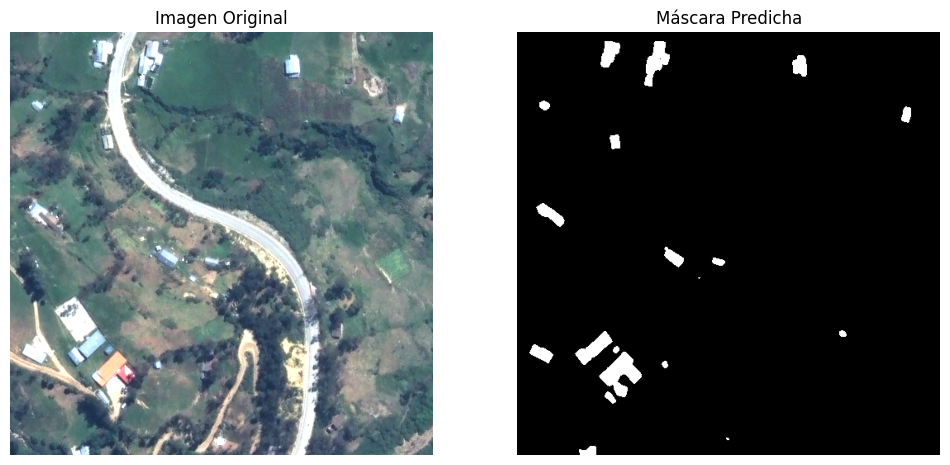

In [4]:
import numpy as np
from tensorflow import keras
import rasterio
import matplotlib.pyplot as plt

ruta_modelo = r"modelo_casas.keras"

modelo_casas = keras.models.load_model(ruta_modelo, compile=False)
print("Modelo cargado.")

# Constantes ImageNet
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

# Ruta de la imagen
image_path = rf"{carpeta_Salida_tiles}\tile_187.tif"

# Leer imagen
with rasterio.open(image_path) as src:
    img = src.read()  # (bands, H, W)
    img = np.moveaxis(img, 0, -1)  # (H, W, bands)

# Solo 3 bandas (RGB)
img_rgb = img[..., :3].astype(np.float32) / 255.0
img_ready = (img_rgb - IMAGENET_MEAN) / IMAGENET_STD
img_ready = np.expand_dims(img_ready, axis=0)  # (1, H, W, 3)

# Predicción
pred = modelo_casas.predict(img_ready, verbose=0)  # (1, H, W, 1) si es binario
mask_pred = (pred[0, :, :, 0] > 0.5).astype(np.uint8)

print("Valores únicos en la máscara predicha:", np.unique(mask_pred))

# Visualización
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Imagen Original")
plt.imshow(img_rgb)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Máscara Predicha")
plt.imshow(mask_pred, cmap="gray")
plt.axis("off")

plt.show()


### Casas y carreteras

In [2]:
from tensorflow import keras

ruta_modelo = r"modelo_carreteras_casas.keras"

model = keras.models.load_model(ruta_modelo, compile=False)
print("Modelo cargado.")

Modelo cargado.


### Predicciones

In [ ]:

from prediccion import predict_tiles_multiclase
# Uso
input_dir = carpeta_Salida_tiles
output_dir = r"MascarasPredichas_Casas_carreteras"

predict_tiles_multiclase(input_dir, output_dir, model)

Encontrados 639 tiles para predecir


Prediciendo tiles: 100%|██████████| 639/639 [02:57<00:00,  3.60it/s]


Predicción completada. Máscaras guardadas en: MascarasPredichas_Casas_carreteras


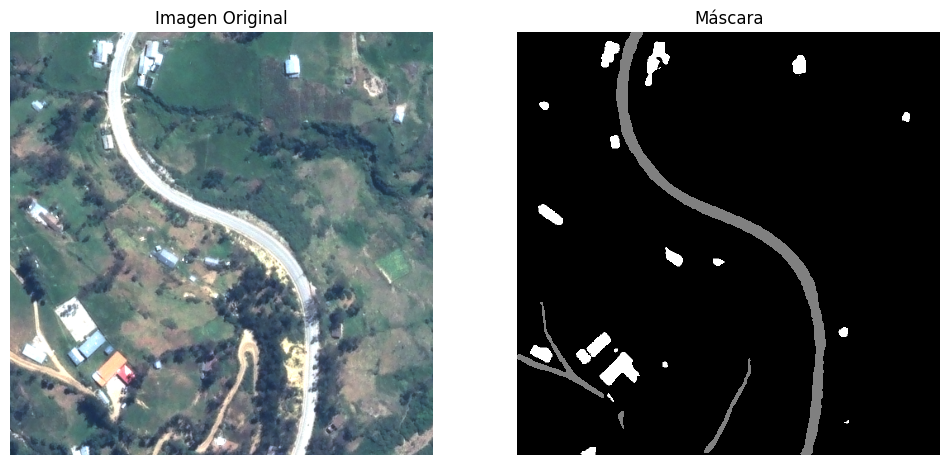

In [3]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Rutas

image_path = rf"{carpeta_Salida_tiles}\tile_187.tif"
mask_path  = r"MascarasPredichas_Casas_carreteras\tile_187.tif"  # tu máscara existente

# Leer imagen RGB
with rasterio.open(image_path) as src:
    img = src.read([1, 2, 3])  # solo las 3 bandas RGB
    img_rgb = np.moveaxis(img, 0, -1) / 255.0  # (H, W, 3) y normalización para mostrar

# Leer máscara
with rasterio.open(mask_path) as src:
    mask = src.read(1).astype(np.uint8)  # (H, W)

# Colormap: fondo=negro, carretera=gris, edificio=blanco (ajusta según tus clases)
cmap = ListedColormap(["black", "gray", "white"])

# Visualización
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Imagen Original")
plt.imshow(img_rgb)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Máscara")
plt.imshow(mask, cmap=cmap)
plt.axis("off")

plt.show()


### Reconstruccion

In [ ]:
from reconstruccion import stitch_tiles_by_class

# 3. Stitch into full tif
carpeta_tiles = carpeta_Salida_tiles
carpeta_predTiles = r"MascarasPredichas_Casas_carreteras"
imagen_saved_path = r"Tif_Clases"

stitch_tiles_by_class(carpeta_tiles, carpeta_predTiles, imagen_saved_path)

Stitching tiles: 100%|██████████| 639/639 [00:02<00:00, 262.62it/s]


Clase 1 guardada en Tif_Clases\class_1.tif
Clase 2 guardada en Tif_Clases\class_2.tif


### Vectorizado de tif

In [ ]:
from to_gpkg import raster_to_vector

import glob
import os

for tif in glob.glob("Tif_Clases/*.tif"):
    nombre = os.path.splitext(os.path.basename(tif))[0]
    salida = f"{nombre}.gpkg"
    raster_to_vector(tif, salida)


Vectorizado guardado en class_2.gpkg
Vectorizado guardado en class_1.gpkg
